In [14]:
import torch
from torch import nn
from torch.utils import data
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython import display

In [15]:
def load_data_fashion_mnist(batch_size, resize=None):
    """下载Fashion-MNIST数据集, 然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True
    )
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True
    )
    return (
        data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=4),
        data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=4)
    )

In [16]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size=batch_size)

In [17]:
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))   ## PyTorch不会隐式地调整输入的形状。因此在线性层前
                                                        ## 定义了展平层（flatten），来调整网络输入的形状

init_weights = lambda m: nn.init.normal_(m.weight, std=0.01)
net[1].apply(init_weights)

Linear(in_features=784, out_features=10, bias=True)

In [18]:
loss = nn.CrossEntropyLoss(reduction='none')

In [19]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

In [20]:
class Accumulator:
    def __init__(self, n):
        self.data = [.0] * n
    def add(self, *args):
        self.data = [a+float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [.0] * len(self.data)
    def __getitem__(self, i):
        return self.data[i]

In [21]:
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [22]:
def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度"""
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [23]:
class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, xlim=None, ylim=None,
                xscale='linear', yscale='linear', legend=None,
                fmts=('-', 'm--', 'g-.', 'r:')):
        ## 增量地绘制多条线
        legend = [] if legend is None else legend
        self.fig, self.axes = plt.gcf(), plt.gca()
        self.config_axes = lambda: self.set_axes(xlabel, ylabel, xlim, ylim, xscale, yscale, legend) ## 使用lambda表达式捕获变量
        self.X, self.Y, self.fmts = None, None, fmts

    def set_axes(self, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        self.axes.set_xlabel(xlabel)
        self.axes.set_ylabel(ylabel)
        self.axes.set_xlim(xlim)
        self.axes.set_ylim(ylim)
        self.axes.set_xscale(xscale)
        self.axes.set_yscale(yscale)
        self.axes.legend(legend)
        self.axes.grid()

    def add(self, x, y):
        """向图表中添加多个数据点"""
        y = [y] if not hasattr(y, "__len__") else y
        x = [x] * len(y) if not hasattr(x, "__len__") else x
        self.X = [[] for _ in range(len(y))] if self.X is None else self.X
        self.Y = [[] for _ in range(len(y))] if self.Y is None else self.Y
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes.cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes.plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [24]:
def train_epoch(net, train_iter, loss, updater):
    """训练模型一个迭代周期"""
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        updater.zero_grad()
        l.mean().backward()
        updater.step()
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

In [25]:
def train(net, train_iter, test_iter, loss, num_epochs, updater):
    """训练模型"""
    animator = Animator(xlabel='epoch', xlim=[1,num_epochs], ylim=[0.3,0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, (train_metrics + (test_acc,)))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

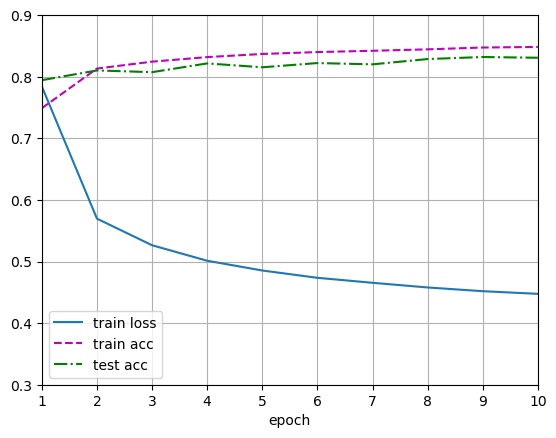

In [26]:
num_epochs = 10
train(net, train_iter, test_iter, loss, num_epochs, trainer)

## Exercises
---

1. 尝试调整超参数，例如批量大小、迭代周期数和学习率，并查看结果

2. 增加迭代周期的数量。为什么测试精度会在一段时间后降低？我们怎么解决这个问题